In [2]:
!pip install opendatasets
!pip install split-folders
# !pip install tensorflow

In [3]:
import opendatasets as od
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report
import splitfolders

### write any name or any passoward >>name: hfdd, password 343433

In [4]:
od.download("https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dfdfd
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset


100%|██████████| 380M/380M [00:00<00:00, 638MB/s]


In [5]:
splitfolders.ratio(
    "/content/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset",
    output="/content/alzheimer_split",
    seed=42,
    ratio=(0.8, 0.2)
)


Copying files: 33984 files [00:04, 7567.80 files/s]


In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/alzheimer_split/train",
    image_size=(224,224),
    batch_size=32
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/alzheimer_split/val",
    image_size=(224,224),
    batch_size=32
)


Found 27187 files belonging to 4 classes.
Found 6797 files belonging to 4 classes.


In [7]:
class_names = train_ds.class_names
print(class_names)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


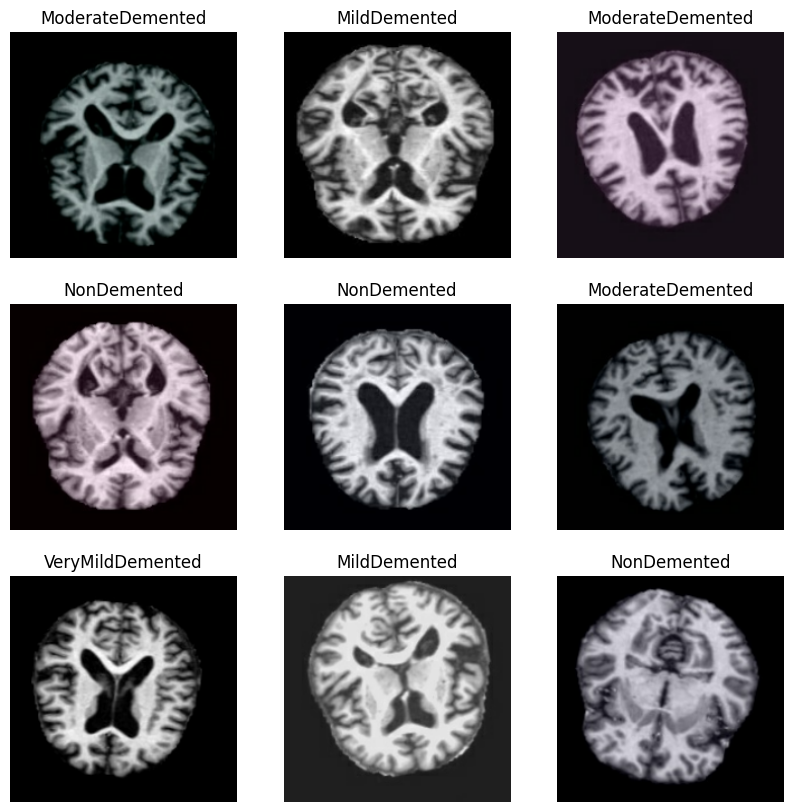

In [8]:
for images,lagels in train_ds.take(1):
  plt.figure(figsize=(10,10))
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[lagels[i]])
    plt.axis("off")

In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
autotune = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=autotune)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=autotune)
print(class_names)


['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [10]:

earlyS = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=7, restore_best_weights=True
)

model = models.Sequential([
    layers.Conv2D(32,(3,3),activation="relu",padding="same",input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation="relu",padding="same"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128,(3,3),activation="relu",padding="same"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256,(3,3),activation="relu",padding="same"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(4, activation="softmax")
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[earlyS]
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 69s 71ms/step - accuracy: 0.4420 - loss: 1.1732 - val_accuracy: 0.6804 - val_loss: 0.7143
Epoch 2/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 56s 66ms/step - accuracy: 0.6604 - loss: 0.7427 - val_accuracy: 0.7643 - val_loss: 0.5487
Epoch 3/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 55s 65ms/step - accuracy: 0.7569 - loss: 0.5596 - val_accuracy: 0.8307 - val_loss: 0.4038
Epoch 4/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 56s 66ms/step - accuracy: 0.8196 - loss: 0.4266 - val_accuracy: 0.8623 - val_loss: 0.3318
Epoch 5/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 56s 66ms/step - accuracy: 0.8585 - loss: 0.3432 - val_accuracy: 0.8958 - val_loss: 0.2649
Epoch 6/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 81s 66ms/step - accuracy: 0.8870 - loss: 0.2700 - val_accuracy: 0.9013 - val_loss: 0.2482
Epoch 7/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 56s 66ms/step - accuracy: 0.9099 - loss: 0.2179 - val_accuracy: 0.9078 - val_loss: 0.2338
Epoch 8/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 61s 71ms/step - accuracy: 0.9243 - loss: 0.1836 - 

In [11]:
loss, acc = model.evaluate(val_ds)
print(f"Validation accuracy = {acc*100:.2f}%")




213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9231 - loss: 0.2043
Validation accuracy = 92.60%


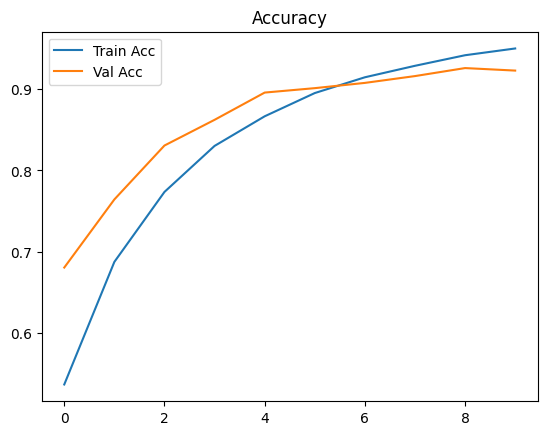

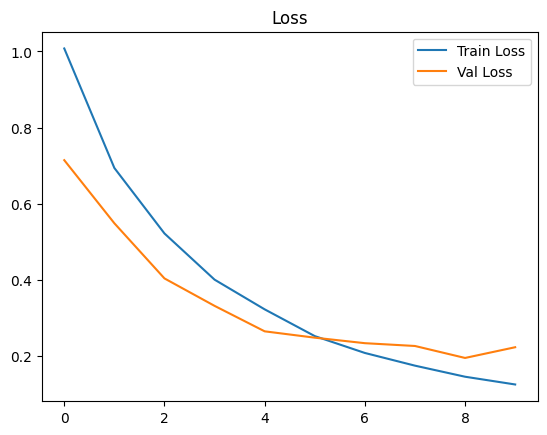

In [12]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()

In [13]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/augmented-alzheimer-mri-dataset/OriginalDataset",
    image_size=(224,224),
    batch_size=32
).map(lambda x,y: (normalization_layer(x), y))

test_loss, test_acc = model.evaluate(test_ds)
print(f"🎯 Test Accuracy on Original Data: {test_acc*100:.2f}%")


Found 6400 files belonging to 4 classes.
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9965 - loss: 0.0172
🎯 Test Accuracy on Original Data: 99.52%


In [14]:
model.save("/content/alzheimer_model.h5")